In [138]:
library(knitr)
library(rmdformats)
library(data.table)
library(magrittr)
library(lubridate)
library(ggplot2)
library(cowplot)
library(repr)
library(kableExtra)
library(IRdisplay)
library(formattable)

library(xgboost)
library(tidymodels)

In [139]:
simulate_central_scenario <- function(seed = 1234){
  
  #seed = 1234  
  set.seed(seed)
  
  # Policy data
  #~~~~~~~~~~~~~~~~~
  
  # polices sold between start 2016 to end 2017
  dt_policydates <- data.table(date_UW = seq(as.Date("2016/1/1"), as.Date("2017/12/31"), "day"))
  
  # number of policies per day follows Poisson process with mean 700 (approx 255,500 pols per annum)
  dt_policydates[, ':='(policycount = rpois(.N,700),
                        date_lapse = date_UW %m+% years(1),
                        expodays = as.integer(date_UW %m+% years(1) - date_UW),
                        pol_prefix = year(date_UW)*10000 + month(date_UW)*100 + mday(date_UW))]
  
  
  # Add columns defining Policy Covers   
  dt_policydates[, Cover_B := round(policycount * 0.25)]
  dt_policydates[, Cover_BO := round(policycount * 0.45)]
  dt_policydates[, Cover_BOT := policycount - Cover_B - Cover_BO]
  
  
  # repeat rows for each policy by UW-Date
  dt_policy <- dt_policydates[rep(1:.N, policycount),c("date_UW", "pol_prefix"), with = FALSE][,pol_seq:=1:.N, by=pol_prefix]
  
  # Create a unique policy number 
  dt_policy[, pol_number := as.character(pol_prefix * 10000 + pol_seq)]
  
  # set join keys
  setkey(dt_policy,'date_UW')
  setkey(dt_policydates,'date_UW')  
  
  # remove pol_prefix before join
  dt_policydates[, pol_prefix := NULL]  
  
  # join cover from summary file (dt_policydates)
  dt_policy <- dt_policy[dt_policydates]  
  
  # now create Cover field for each policy row
  dt_policy[,Cover := 'BO']
  dt_policy[pol_seq <= policycount- Cover_BO,Cover := 'BOT']
  dt_policy[pol_seq <= Cover_B,Cover := 'B']  
  
  # remove interim calculation fields
  dt_policy[, ':='(pol_prefix = NULL,
                   policycount = NULL,
                   pol_seq = NULL,
                   Cover_B = NULL,
                   Cover_BOT = NULL,
                   Cover_BO = NULL)]
  
  # Add remaining policy details
  dt_policy[, Brand := rep(rep(c(1,2,3,4), c(9,6,3,2)), length.out = .N)]
  dt_policy[, Base_Price := rep(rep(c(600,550,300,150), c(9,6,3,2)), length.out = .N)]
  
  # models types and model cost multipliers
  for (eachBrand in unique(dt_policy$Brand)) {
    dt_policy[Brand == eachBrand, Model := rep(rep(c(3,2,1,0), c(10, 7, 2, 1)), length.out = .N)]
    dt_policy[Brand == eachBrand, Model_mult := rep(rep(c(1.15^3, 1.15^2, 1.15^1, 1.15^0), c(10, 7, 2, 1)), length.out = .N)]
  }
  
  dt_policy[, Price := ceiling (Base_Price * Model_mult)]
  
  
  # colums to keep
  cols_policy <- c("pol_number",
                   "date_UW",
                   "date_lapse",
                   "Cover",
                   "Brand",
                   "Model",
                   "Price")
  
  dt_policy <- dt_policy[, cols_policy, with = FALSE]
  
  # check output
  head(dt_policy)
  
  #save(dt_policy, file = "./dt_policy.rda")
  
  
  # Claims data
  #~~~~~~~~~~~~~~~~~
  
 # All policies have breakage cover
  # claims uniformly sampled from policies
  claim <- sample(nrow(dt_policy), size = floor(nrow(dt_policy) * 0.15))
  
  # Claim serverity multiplier sampled from beta distn
  dt_claim <- data.table(pol_number = dt_policy[claim, pol_number],
                         claim_type = 'B',
                         claim_count = 1,
                         claim_sev = rbeta(length(claim), 2,5))
  
  # identify all policies with Oxidation cover
  cov <- which(dt_policy$Cover != 'B')
  
  # sample claims from policies with cover
  claim <- sample(cov, size = floor(length(cov) * 0.05))
  
  # add claims to table 
  dt_claim <- rbind(dt_claim,
                    data.table(pol_number = dt_policy[claim, pol_number],
                               claim_type = 'O',
                               claim_count = 1,
                               claim_sev = rbeta(length(claim), 5,3)))
  
  
  # identify all policies with Theft cover
  # for Theft claim frequency varies by Brand
  # So need to consider each in turn...
  
  for(myModel in 0:3) {
    
    cov <- which(dt_policy$Cover == 'BOT' & dt_policy$Model == myModel)
    claim <- sample(cov, size = floor(length(cov) * 0.05*(1 + myModel)))
    
    dt_claim <- rbind(dt_claim,
                      data.table(pol_number = dt_policy[claim, pol_number],
                                 claim_type = 'T',
                                 claim_count = 1,
                                 claim_sev = rbeta(length(claim), 5,.5)))
  }
  
  # set join keys
  setkey(dt_policy, pol_number)
  setkey(dt_claim, pol_number)
  
  #join Brand and Price from policy to claim
  dt_claim[dt_policy,
           on = 'pol_number',
           ':='(date_UW = i.date_UW,
                Price = i.Price,
                Brand = i.Brand)]
  
  # use lubridate %m+% date addition operator 
  dt_claim[, date_lapse := date_UW %m+% years(1)]
  dt_claim[, expodays := as.integer(date_lapse - date_UW)]
  dt_claim[, occ_delay_days := floor(expodays * runif(.N, 0,1))]
  
  dt_claim[ ,delay_report := floor(365 * rbeta(.N, .4, 10))]  
  dt_claim[ ,delay_pay := floor(10 + 40* rbeta(.N, 7,7))]  
  
  dt_claim[, date_occur := date_UW %m+% days(occ_delay_days)]
  dt_claim[, date_report := date_occur %m+% days(delay_report)]
  dt_claim[, date_pay := date_report %m+% days(delay_pay)]
  
  dt_claim[, claim_cost := round(Price * claim_sev)]
  
  dt_claim[, clm_prefix := year(date_report)*10000 + month(date_report)*100 + mday(date_report)]
  
  dt_claim[, clm_seq := seq_len(.N), by = clm_prefix]
  dt_claim[, clm_number := as.character(clm_prefix * 10000 + clm_seq)]
  
  # colums to keep
  cols_claim <- c("clm_number",
                  "pol_number",
                  "claim_type",
                  "claim_count",
                  "claim_sev",
                  "date_occur",
                  "date_report",
                  "date_pay",
                  "claim_cost")
  
  dt_claim <- dt_claim[, cols_claim, with = FALSE]
  
 output <- list()
 output$dt_policy <- dt_policy
 output$dt_claim <- dt_claim

 return(output)

  
  
}

In [140]:
dt_PhoneData <- simulate_central_scenario(1234)

In [141]:
dt_policy <- dt_PhoneData$dt_policy

In [142]:
head(dt_policy)

pol_number,date_UW,date_lapse,Cover,Brand,Model,Price
<chr>,<date>,<date>,<chr>,<dbl>,<dbl>,<dbl>
201601010001,2016-01-01,2017-01-01,B,1,3,913
201601010002,2016-01-01,2017-01-01,B,1,3,913
201601010003,2016-01-01,2017-01-01,B,1,3,913
201601010004,2016-01-01,2017-01-01,B,1,3,913
201601010005,2016-01-01,2017-01-01,B,1,3,913
201601010006,2016-01-01,2017-01-01,B,1,3,913


In [143]:
dt_claim <- dt_PhoneData$dt_claim

kable(head(dt_claim), "html") %>% 
  kable_styling(c("striped", "hover", "condensed")) %>% 
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

clm_number,pol_number,claim_type,claim_count,claim_sev,date_occur,date_report,date_pay,claim_cost
201606080001,201601010001,B,1,0.3337923,2016-06-08,2016-06-08,2016-07-21,305
201609150001,201601010014,B,1,0.3692034,2016-09-15,2016-09-15,2016-10-17,309
201609090001,201601010025,B,1,0.4496012,2016-09-09,2016-09-09,2016-10-07,357
201602190001,201601010027,B,1,0.4019731,2016-01-25,2016-02-19,2016-03-21,319
201605140001,201601010043,B,1,0.2146653,2016-05-14,2016-05-14,2016-06-15,196
201612110001,201601010045,B,1,0.2783313,2016-12-11,2016-12-11,2017-01-06,254


In [144]:
# add a unique claimkey based upon occurence date

dt_claim[, clm_prefix := year(date_occur)*10000 + month(date_occur)*100 + mday(date_occur)]
dt_claim[, clm_seq := seq_len(.N), by = clm_prefix]
dt_claim[, clm_number := as.character(clm_prefix * 10000 + clm_seq)]


# keep only first claim against policy (competing hazards)
setkeyv(dt_claim, c("pol_number", "clm_prefix"))
dt_claim[, polclm_seq := seq_len(.N), by = .(pol_number)]
dt_claim <- dt_claim[polclm_seq == 1,]

# colums to keep
cols_claim <- c("clm_number",
                "pol_number",
                "claim_type",
                "claim_count",
                "claim_sev",
                "date_occur",
                "date_report",
                "date_pay",
                "claim_cost")

dt_claim <- dt_claim[, cols_claim, with = FALSE]

# check output
kable(head(dt_claim), "html") %>%
  kable_styling("striped") %>%
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

clm_number,pol_number,claim_type,claim_count,claim_sev,date_occur,date_report,date_pay,claim_cost
201606080001,201601010001,B,1,0.3337923,2016-06-08,2016-06-08,2016-07-21,305
201609150001,201601010014,B,1,0.3692034,2016-09-15,2016-09-15,2016-10-17,309
201609090001,201601010025,B,1,0.4496012,2016-09-09,2016-09-09,2016-10-07,357
201601250001,201601010027,B,1,0.4019731,2016-01-25,2016-02-19,2016-03-21,319
201605140001,201601010043,B,1,0.2146653,2016-05-14,2016-05-14,2016-06-15,196
201612110001,201601010045,B,1,0.2783313,2016-12-11,2016-12-11,2017-01-06,254


In [145]:
setnames(dt_policy, c('date_UW', 'date_lapse'), c('date_pol_start', 'date_pol_end'))
  
# set policy start and end dates in foverlap friendly format
dt_policy[, date_pol_start:= floor_date(date_pol_start, unit= "second")]
dt_policy[, date_pol_end:= floor_date(date_pol_end, unit= "second") - 1]
  
# create a dummy end claim occurrence date for foverlap
dt_claim[, date_occur:= floor_date(date_occur, unit= "second")]
dt_claim[, date_occur_end:= date_occur]
dt_claim[, date_report:= floor_date(date_report, unit= "second")]
dt_claim[, date_pay:= floor_date(date_pay, unit= "second")]
  
# set keys for claim join (by policy and dates)
setkey(dt_claim, pol_number, date_occur, date_occur_end)
setkey(dt_policy, pol_number, date_pol_start, date_pol_end)
  
# use foverlaps to attach claim to right occurrence period and policy
dt_polclaim <- foverlaps(dt_policy, dt_claim, type="any") ## return overlap indices
dt_polclaim[, date_occur_end := NULL]

In [146]:
head(dt_polclaim)

pol_number,clm_number,claim_type,claim_count,claim_sev,date_occur,date_report,date_pay,claim_cost,date_pol_start,date_pol_end,Cover,Brand,Model,Price
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dttm>,<dttm>,<dttm>,<dbl>,<dttm>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>
201601010001,201606080001,B,1,0.3337923,2016-06-08,2016-06-08,2016-07-21,305,2016-01-01,2016-12-31 23:59:59,B,1,3,913
201601010002,NA,NA,NA,NA,NA,NA,NA,NA,2016-01-01,2016-12-31 23:59:59,B,1,3,913
201601010003,NA,NA,NA,NA,NA,NA,NA,NA,2016-01-01,2016-12-31 23:59:59,B,1,3,913
201601010004,NA,NA,NA,NA,NA,NA,NA,NA,2016-01-01,2016-12-31 23:59:59,B,1,3,913
201601010005,NA,NA,NA,NA,NA,NA,NA,NA,2016-01-01,2016-12-31 23:59:59,B,1,3,913
201601010006,NA,NA,NA,NA,NA,NA,NA,NA,2016-01-01,2016-12-31 23:59:59,B,1,3,913


In [147]:
setkey(dt_polclaim, pol_number, date_pol_start)
  
# create 2 new cols that count how many claims against each policy
dt_polclaim[,
            ':='(pol_seq = seq_len(.N),
                 pol_seq_max = .N),
            by = c('pol_number', 'date_pol_start') ]
  
table(dt_polclaim[, pol_seq_max])


     1 
512246 

In [148]:
#set NA dates to 31/12/2999
lst_datefields <- grep(names(dt_polclaim),pattern = "date", value = TRUE)
  
for (datefield in lst_datefields)
  set(dt_polclaim,which(is.na(dt_polclaim[[datefield]])),datefield,as_datetime("2199-12-31 23:59:59 UTC"))
 
#set other NAs to zero (claim counts and costs)
for (field in c("claim_count", "claim_sev", "claim_cost"))
  set(dt_polclaim,which(is.na(dt_polclaim[[field]])),field,0)


In [149]:

#Clean up ----
dt_polclaim[, ExpoDays:= ceiling((as.numeric(date_pol_end) - as.numeric(date_pol_start))/(24*60*60*365))]
dt_polclaim <- dt_polclaim[ExpoDays > 0]
  
rm(dt_claim)
rm(dt_policy)
  
gc()

     

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3052801,163.1,6653944,355.4,6653944,355.4
Vcells,23209710,177.1,78799218,601.2,79633472,607.6


In [150]:
head(dt_polclaim)

pol_number,clm_number,claim_type,claim_count,claim_sev,date_occur,date_report,date_pay,claim_cost,date_pol_start,date_pol_end,Cover,Brand,Model,Price,pol_seq,pol_seq_max,ExpoDays
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dttm>,<dttm>,<dttm>,<dbl>,<dttm>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>
201601010001,201606080001,B,1,0.3337923,2016-06-08 00:00:00,2016-06-08 00:00:00,2016-07-21 00:00:00,305,2016-01-01,2016-12-31 23:59:59,B,1,3,913,1,1,2
201601010002,NA,NA,0,0.0000000,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,0,2016-01-01,2016-12-31 23:59:59,B,1,3,913,1,1,2
201601010003,NA,NA,0,0.0000000,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,0,2016-01-01,2016-12-31 23:59:59,B,1,3,913,1,1,2
201601010004,NA,NA,0,0.0000000,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,0,2016-01-01,2016-12-31 23:59:59,B,1,3,913,1,1,2
201601010005,NA,NA,0,0.0000000,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,0,2016-01-01,2016-12-31 23:59:59,B,1,3,913,1,1,2
201601010006,NA,NA,0,0.0000000,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,0,2016-01-01,2016-12-31 23:59:59,B,1,3,913,1,1,2


In [151]:

lst_Date_slice <- floor_date(seq(as.Date("2016/1/1"), as.Date("2019/06/30"), by = 30), unit= "second") 

# Time slice Policy & claims 
 
for (i in 1:length(lst_Date_slice)){
  dt_polclaim[date_pay<= lst_Date_slice[i], paste0('P_t_', format(lst_Date_slice[i], "%Y%m%d")):= claim_cost]
  set(dt_polclaim,which(is.na(dt_polclaim[[paste0('P_t_', format(lst_Date_slice[i], "%Y%m%d"))]])),paste0('P_t_', format(lst_Date_slice[i], "%Y%m%d")),0)
}
  
# sort data by policynumber
setkey(dt_polclaim, pol_number)

In [152]:

head(dt_polclaim)

pol_number,clm_number,claim_type,claim_count,claim_sev,date_occur,date_report,date_pay,claim_cost,date_pol_start,...,P_t_20180917,P_t_20181017,P_t_20181116,P_t_20181216,P_t_20190115,P_t_20190214,P_t_20190316,P_t_20190415,P_t_20190515,P_t_20190614
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dttm>,<dttm>,<dttm>,<dbl>,<dttm>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
201601010001,201606080001,B,1,0.3337923,2016-06-08 00:00:00,2016-06-08 00:00:00,2016-07-21 00:00:00,305,2016-01-01,...,305,305,305,305,305,305,305,305,305,305
201601010002,NA,NA,0,0.0000000,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,0,2016-01-01,...,0,0,0,0,0,0,0,0,0,0
201601010003,NA,NA,0,0.0000000,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,0,2016-01-01,...,0,0,0,0,0,0,0,0,0,0
201601010004,NA,NA,0,0.0000000,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,0,2016-01-01,...,0,0,0,0,0,0,0,0,0,0
201601010005,NA,NA,0,0.0000000,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,0,2016-01-01,...,0,0,0,0,0,0,0,0,0,0
201601010006,NA,NA,0,0.0000000,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,0,2016-01-01,...,0,0,0,0,0,0,0,0,0,0


In [153]:

i <- valuation <- 10
t_i <- lst_Date_slice[i] 
delta <- min(i, length(lst_Date_slice) - i + 1)
     

In [154]:
RBNS_Train_ijk <- function(dt_policy_claim, date_i, j_dev_period, k, reserving_dates, model_vars) {
  
  date_i <- as.Date(date_i)
  date_k <- (reserving_dates[which(reserving_dates == date_i) - k + 1])
  date_j <- (reserving_dates[which(reserving_dates == date_k) - j_dev_period])
  
  # i - j - k + 1 (predictor as at date)
  date_lookup <- (reserving_dates[which(reserving_dates == (date_i)) - j_dev_period - k + 1]) 
  
  # i - k to calculate target incremental paid (not needed now but keeping flow same)
  target_lookup <- (reserving_dates[which(reserving_dates == (date_i)) - k]) 
  target_lookup_next <- (reserving_dates[which(reserving_dates == (date_i)) - k + 1]) 
  
  # Select RBNS policies
  dt_policy_claim <- dt_policy_claim[(date_report <= date_lookup) & (date_pay > date_lookup)] 
  
  # Simulated data assumes one payment so just need to check date paid in target calc
  dt_policy_claim[, ':='(
    date_lookup = date_lookup,
    delay_train = as.numeric(date_lookup - date_pol_start), # extra feature
    j = j_dev_period,
    k = k,
    
    # NEW target: payment delay in days
    target = ceiling((as.numeric(date_pay) - as.numeric(date_report)) / (24 * 60 * 60)),
    
    # Also add actual delay as separate field for later comparison
    delay_rep_pay = ceiling((as.numeric(date_pay) - as.numeric(date_report)) / (24 * 60 * 60))
  )]
  
  return(dt_policy_claim[, model_vars, with = FALSE])
}


In [155]:
RBNS_Test_ijk <- function(dt_policy_claim, date_i, j_dev_period, k, reserving_dates, model_vars) {
  
  date_i <- as.Date(date_i)
  
  # i - j - k + 1 (predictor as at date)
  date_lookup <- (reserving_dates[which(reserving_dates == (date_i))]) 
  
  # i - k to calculate target incremental paid (not needed now but keeping flow same)
  target_lookup <- (reserving_dates[which(reserving_dates == (date_i)) + j_dev_period - 1]) 
  target_lookup_next <- (reserving_dates[which(reserving_dates == (date_i)) + j_dev_period]) 
  
  # Select RBNS policies
  dt_policy_claim <- dt_policy_claim[date_report <= date_lookup & date_lookup < date_pay] 
  
  # Simulated data assumes one payment so just need to check date paid
  dt_policy_claim[, ':='(
    date_lookup = date_lookup,
    delay_train = as.numeric(date_lookup - date_pol_start), # extra feature
    j = j_dev_period,
    k = k,
    
    # NEW target: payment delay in days
    target = ceiling((as.numeric(date_pay) - as.numeric(date_report)) / (24 * 60 * 60)),
    
    # Also add actual delay as separate field for later comparison
    delay_rep_pay = ceiling((as.numeric(date_pay) - as.numeric(date_report)) / (24 * 60 * 60))
  )]
  
  return(dt_policy_claim[, model_vars, with = FALSE])
}


In [156]:
RBNS_Train <- function(dt_policy_claim, date_i, i, k, reserving_dates, model_vars) {
# Create a combined TRAIN dataset across all k and j combos
  for (k in 1:k){
    if (k==1) dt_train <- NULL
    for (j in 1:(i - k + 1)){
      dt_train <- rbind(dt_train, RBNS_Train_ijk(dt_polclaim, date_i, j, k,reserving_dates, model_vars))
    }
  }  
  return(dt_train)
}

In [157]:
RBNS_Test <- function(dt_policy_claim, date_i, delta, k, reserving_dates, model_vars) {
  
  # Create a combined TEST dataset across all k and j combos
  for (k in 1:k){
    if (k==1) dt_test <- NULL
    for (j in 1:(delta - k + 1)){
      dt_test <- rbind(dt_test, RBNS_Test_ijk(dt_polclaim, date_i, j, k,reserving_dates, model_vars))
    }
  }
  
  return(dt_test)
}


In [158]:
RBNS_model_vars_delay <- c("clm_number", "pol_number", "j", "k", "date_pol_start", "date_occur", 
                           "date_report", "date_pay", "Cover", "claim_type", "Brand", "Model", "Price", 
                           "target", "delay_rep_pay")

dt_RBNS_train_delay <- RBNS_Train(dt_polclaim, t_i, i, k = 1, lst_Date_slice, RBNS_model_vars_delay)
dt_RBNS_test_delay  <- RBNS_Test(dt_polclaim, t_i, delta, k = 1, lst_Date_slice, RBNS_model_vars_delay)


In [159]:
dt_RBNS_train_delay[, flgTrain := 1]
dt_RBNS_test_delay[, flgTrain := 0]

In [160]:
head(dt_RBNS_train_delay)
dim(dt_RBNS_train_delay)

clm_number,pol_number,j,k,date_pol_start,date_occur,date_report,date_pay,Cover,claim_type,Brand,Model,Price,target,delay_rep_pay,flgTrain
<chr>,<chr>,<int>,<int>,<dttm>,<dttm>,<dttm>,<dttm>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
201607150001,201601010103,1,1,2016-01-01,2016-07-15,2016-08-04,2016-09-02,B,B,1,3,913,29,29,1
201605110001,201601010130,1,1,2016-01-01,2016-05-11,2016-08-11,2016-09-14,B,B,2,2,728,34,34,1
201608020001,201601010141,1,1,2016-01-01,2016-08-02,2016-08-17,2016-09-16,B,B,1,3,913,30,30,1
201608280001,201601010145,1,1,2016-01-01,2016-08-28,2016-08-28,2016-09-24,B,B,1,3,913,27,27,1
201608190001,201601010190,1,1,2016-01-01,2016-08-19,2016-08-19,2016-09-21,BOT,T,2,2,728,33,33,1
201606230001,201601010194,1,1,2016-01-01,2016-06-23,2016-08-13,2016-09-11,BOT,B,2,1,633,29,29,1


[1] 11425    16

In [161]:
head(dt_RBNS_test_delay)
dim(dt_RBNS_test_delay)

clm_number,pol_number,j,k,date_pol_start,date_occur,date_report,date_pay,Cover,claim_type,Brand,Model,Price,target,delay_rep_pay,flgTrain
<chr>,<chr>,<int>,<int>,<dttm>,<dttm>,<dttm>,<dttm>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
201609150001,201601010014,1,1,2016-01-01,2016-09-15,2016-09-15,2016-10-17,B,B,2,3,837,32,32,0
201609090001,201601010025,1,1,2016-01-01,2016-09-09,2016-09-09,2016-10-07,B,B,1,2,794,28,28,0
201609020001,201601010212,1,1,2016-01-01,2016-09-02,2016-09-22,2016-10-20,BOT,T,2,3,837,28,28,0
201606060001,201601010261,1,1,2016-01-01,2016-06-06,2016-09-02,2016-10-01,BOT,T,1,1,690,29,29,0
201608250001,201601010284,1,1,2016-01-01,2016-08-25,2016-09-06,2016-10-09,BOT,T,1,3,913,33,33,0
201609200001,201601010327,1,1,2016-01-01,2016-09-20,2016-09-20,2016-10-26,BOT,T,1,2,794,36,36,0


[1] 32150    16

In [162]:

#fwrite(dt_RBNS_train_delay, file = "RBNS_train_delay.csv")


#fwrite(dt_RBNS_test_delay, file = "RBNS_test_delay.csv")


dt_All_RBNS_delay <- rbind(dt_RBNS_train_delay, dt_RBNS_test_delay)
#fwrite(dt_All_RBNS_delay, file = "RBNS_all_delay.csv")


In [163]:
head(dt_All_RBNS_delay)
dim(dt_All_RBNS_delay)  # Returns c(number_of_rows, number_of_columns)

clm_number,pol_number,j,k,date_pol_start,date_occur,date_report,date_pay,Cover,claim_type,Brand,Model,Price,target,delay_rep_pay,flgTrain
<chr>,<chr>,<int>,<int>,<dttm>,<dttm>,<dttm>,<dttm>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
201607150001,201601010103,1,1,2016-01-01,2016-07-15,2016-08-04,2016-09-02,B,B,1,3,913,29,29,1
201605110001,201601010130,1,1,2016-01-01,2016-05-11,2016-08-11,2016-09-14,B,B,2,2,728,34,34,1
201608020001,201601010141,1,1,2016-01-01,2016-08-02,2016-08-17,2016-09-16,B,B,1,3,913,30,30,1
201608280001,201601010145,1,1,2016-01-01,2016-08-28,2016-08-28,2016-09-24,B,B,1,3,913,27,27,1
201608190001,201601010190,1,1,2016-01-01,2016-08-19,2016-08-19,2016-09-21,BOT,T,2,2,728,33,33,1
201606230001,201601010194,1,1,2016-01-01,2016-06-23,2016-08-13,2016-09-11,BOT,B,2,1,633,29,29,1


[1] 43575    16

In [164]:
# order and create some delay fields
setkey(dt_All_RBNS_delay, clm_number, k, j)
    
dt_All_RBNS_delay[, Count := .N , by =clm_number]

#create date and delay measure by converting from source seconds since 01/01/1970 to day periods

dt_All_RBNS_delay[, ':='(
  delay_uw_occ = ifelse(year(date_occur) == 2199,
                        -1,
                        ceiling((as.numeric(date_occur) - as.numeric(date_pol_start)) / (24 * 60 * 60))
                        ),
  delay_occ_rep = ifelse(year(date_occur) == 2199,
                         -1,
                         ceiling((as.numeric(date_report) - as.numeric(date_occur)) / (24 * 60 * 60))
                         ),
  
  delay_uw_val = ceiling((as.numeric(t_i) - as.numeric(date_pol_start)) / (24 * 60 * 60)),
  delay_rep_pay = ceiling((as.numeric(date_pay) - as.numeric(date_report)) / (24 * 60 * 60)),
  date_uw = ceiling(as.numeric(date_pol_start) / (24 *  60 * 60)),
  
  Cover = as.factor(Cover),
  claim_type = as.factor(claim_type)
  )]
  


In [165]:
head(dt_All_RBNS_delay)

clm_number,pol_number,j,k,date_pol_start,date_occur,date_report,date_pay,Cover,claim_type,...,Model,Price,target,delay_rep_pay,flgTrain,Count,delay_uw_occ,delay_occ_rep,delay_uw_val,date_uw
<chr>,<chr>,<int>,<int>,<dttm>,<dttm>,<dttm>,<dttm>,<fct>,<fct>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
201601040001,201601010451,8,1,2016-01-01,2016-01-04,2016-01-12,2016-02-08,BO,B,...,2,728,27,27,1,1,3,8,270,16801
201601040002,201601030437,8,1,2016-01-03,2016-01-04,2016-01-28,2016-02-29,BO,O,...,3,837,32,32,1,1,1,24,268,16803
201601040003,201601040050,7,1,2016-01-04,2016-01-04,2016-02-13,2016-03-14,B,B,...,3,837,30,30,1,1,0,40,267,16804
201601050001,201601020447,7,1,2016-01-02,2016-01-05,2016-02-12,2016-03-18,BO,B,...,2,728,35,35,1,1,3,38,269,16802
201601060001,201601020675,8,1,2016-01-02,2016-01-06,2016-01-22,2016-02-26,BO,B,...,3,913,35,35,1,1,4,16,269,16802
201601060002,201601050343,8,1,2016-01-05,2016-01-06,2016-01-06,2016-02-08,BOT,B,...,3,913,33,33,1,1,1,0,266,16805


In [166]:
#fwrite(dt_All_RBNS_delay, file = "RBNS_all_delay1.csv")

In [167]:
RBNS_predictors_delay <- c("j",
                           "k",
                           "Cover",
                           "claim_type",
                           "Brand",
                           "Model",
                           "Price",
                           "delay_uw_val",
                           "delay_occ_rep")


rowList_RBNS_delay <- list(train = dt_All_RBNS_delay[, which(flgTrain == 1)],
                           test  = dt_All_RBNS_delay[, which(flgTrain == 0)],
                           all   = 1:nrow(dt_All_RBNS_delay))

# Now dt_All_RBNS_delay is still your data.table — this will now work:
library(recipes)

RBNS_rec_delay <- recipe( ~ ., data = dt_All_RBNS_delay[, RBNS_predictors_delay, with = FALSE]) %>%
  step_dummy(all_nominal(), one_hot = TRUE) %>%
  prep()

# Proceed as before:
df.RBNS_train_delay <- bake(RBNS_rec_delay, new_data = dt_All_RBNS_delay[rowList_RBNS_delay$train, ])
df.RBNS_test_delay  <- bake(RBNS_rec_delay, new_data = dt_All_RBNS_delay[rowList_RBNS_delay$test, ])
df.RBNS_all_delay   <- bake(RBNS_rec_delay, new_data = dt_All_RBNS_delay)

xgb.RBNS_DMat.train_delay <- xgb.DMatrix(data = as.matrix(df.RBNS_train_delay),
                                        label = dt_All_RBNS_delay[rowList_RBNS_delay$train, target])

xgb.RBNS_DMat.test_delay <- xgb.DMatrix(data = as.matrix(df.RBNS_test_delay),
                                       label = dt_All_RBNS_delay[rowList_RBNS_delay$test, target])

xgb.RBNS_DMat.all_delay <- xgb.DMatrix(data = as.matrix(df.RBNS_all_delay),
                                      label = dt_All_RBNS_delay[, target])


In [168]:
rowList_RBNS_delay

$train
    [1]     1     2     3     4     5     6     7     8     9    10    11    12
   [13]    13    14    15    16    17    18    19    20    21    22    23    24
   [25]    25    26    27    28    29    30    31    32    33    34    35    36
   [37]    37    38    39    40    41    42    43    44    45    46    47    48
   [49]    49    50    51    52    53    54    55    56    57    58    59    60
   [61]    61    62    63    64    65    66    67    68    69    70    71    72
   [73]    73    74    75    76    77    78    79    80    81    82    83    84
   [85]    85    86    87    88    89    90    91    92    93    94    95    96
   [97]    97    98    99   100   101   102   103   104   105   106   107   108
  [109]   109   110   111   112   113   114   115   116   117   118   119   120
  [121]   121   122   123   124   125   126   127   128   129   130   131   132
  [133]   133   134   135   136   137   138   139   140   141   142   143   144
  [145]   145   146   147   148   149   150   151   152   153   154   155   156
  [157]   157   158   159   160   161   162   163   164   165   166   167   168
  [169]   169   170   171   172   173   174   175   176   177   178   179   180
  [181]   181   182   183   184   185   186   187   188   189   190   191   192
  [193]   193   194   195   196   197   198   199   200   201   202   203   204
  [205]   205   206   207   208   209   210   211   212   213   214   215   216
  [217]   217   218   219   220   221   222   223   224   225   226   227   228
  [229]   229   230   231   232   233   234   235   236   237   238   239   240
  [241]   241   242   243   244   245   246   247   248   249   250   251   252
  [253]   253   254   255   256   257   258   259   260   261   262   263   264
  [265]   265   266   267   268   269   270   271   272   273   274   275   276
  [277]   277   278   279   280   281   282   283   284   285   286   287   288
  [289]   289   290   291   292   293   294   295   296   297   298   299   300
  [301]   301   302   303   304   305   306   307   308   309   310   311   312
  [313]   313   314   315   316   317   318   319   320   321   322   323   324
  [325]   325   326   327   328   329   330   331   332   333   334   335   336
  [337]   337   338   339   340   341   342   343   344   345   346   347   348
  [349]   349   350   351   352   353   354   355   356   357   358   359   360
  [361]   361   362   363   364   365   366   367   368   369   370   371   372
  [373]   373   374   375   376   377   378   379   380   381   382   383   384
  [385]   385   386   387   388   389   390   391   392   393   394   395   396
  [397]   397   398   399   400   401   402   403   404   405   406   407   408
  [409]   409   410   411   412   413   414   415   416   417   418   419   420
  [421]   421   422   423   424   425   426   427   428   429   430   431   432
  [433]   433   434   435   436   437   438   439   440   441   442   443   444
  [445]   445   446   447   448   449   450   451   452   453   454   455   456
  [457]   457   458   459   460   461   462   463   464   465   466   467   468
  [469]   469   470   471   472   473   474   475   476   477   478   479   480
  [481]   481   482   483   484   485   486   487   488   489   490   491   492
  [493]   493   494   495   496   497   498   499   500   501   502   503   504
  [505]   505   506   507   508   509   510   511   512   513   514   515   516
  [517]   517   518   519   520   521   522   523   524   525   526   527   528
  [529]   529   530   531   532   533   534   535   536   537   538   539   540
  [541]   541   542   543   544   545   546   547   548   549   550   551   552
  [553]   553   554   555   556   557   558   559   560   561   562   563   564
  [565]   565   566   567   568   569   570   571   572   573   574   575   576
  [577]   577   578   579   580   581   582   583   584   585   586   587   588
  [589]   589   590   591   592   593   594   595   596   597   598   599

In [169]:
head(df.RBNS_train_delay)

j,k,Brand,Model,Price,delay_uw_val,delay_occ_rep,Cover_B,Cover_BO,Cover_BOT,claim_type_B,claim_type_O,claim_type_T
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8,1,2,2,728,270,8,0,1,0,1,0,0
8,1,2,3,837,268,24,0,1,0,0,1,0
7,1,2,3,837,267,40,1,0,0,1,0,0
7,1,2,2,728,269,38,0,1,0,1,0,0
8,1,1,3,913,269,16,0,1,0,1,0,0
8,1,1,3,913,266,0,0,0,1,1,0,0


In [170]:
head(df.RBNS_test_delay)

j,k,Brand,Model,Price,delay_uw_val,delay_occ_rep,Cover_B,Cover_BO,Cover_BOT,claim_type_B,claim_type_O,claim_type_T
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,2,3,837,249,146,0,1,0,0,1,0
2,1,2,3,837,249,146,0,1,0,0,1,0
3,1,2,3,837,249,146,0,1,0,0,1,0
4,1,2,3,837,249,146,0,1,0,0,1,0
5,1,2,3,837,249,146,0,1,0,0,1,0
6,1,2,3,837,249,146,0,1,0,0,1,0


In [171]:
head(df.RBNS_all_delay)

j,k,Brand,Model,Price,delay_uw_val,delay_occ_rep,Cover_B,Cover_BO,Cover_BOT,claim_type_B,claim_type_O,claim_type_T
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8,1,2,2,728,270,8,0,1,0,1,0,0
8,1,2,3,837,268,24,0,1,0,0,1,0
7,1,2,3,837,267,40,1,0,0,1,0,0
7,1,2,2,728,269,38,0,1,0,1,0,0
8,1,1,3,913,269,16,0,1,0,1,0,0
8,1,1,3,913,266,0,0,0,1,1,0,0


In [172]:
xgb.RBNS_DMat.train_delay

xgb.DMatrix  dim: 11425 x 13  info: label  colnames: yes

In [173]:
xgb.RBNS_DMat.test_delay

xgb.DMatrix  dim: 32150 x 13  info: label  colnames: yes

In [174]:
xgb.RBNS_DMat.all_delay

xgb.DMatrix  dim: 43575 x 13  info: label  colnames: yes

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  11.00   27.00   30.00   30.34   34.00   46.00 

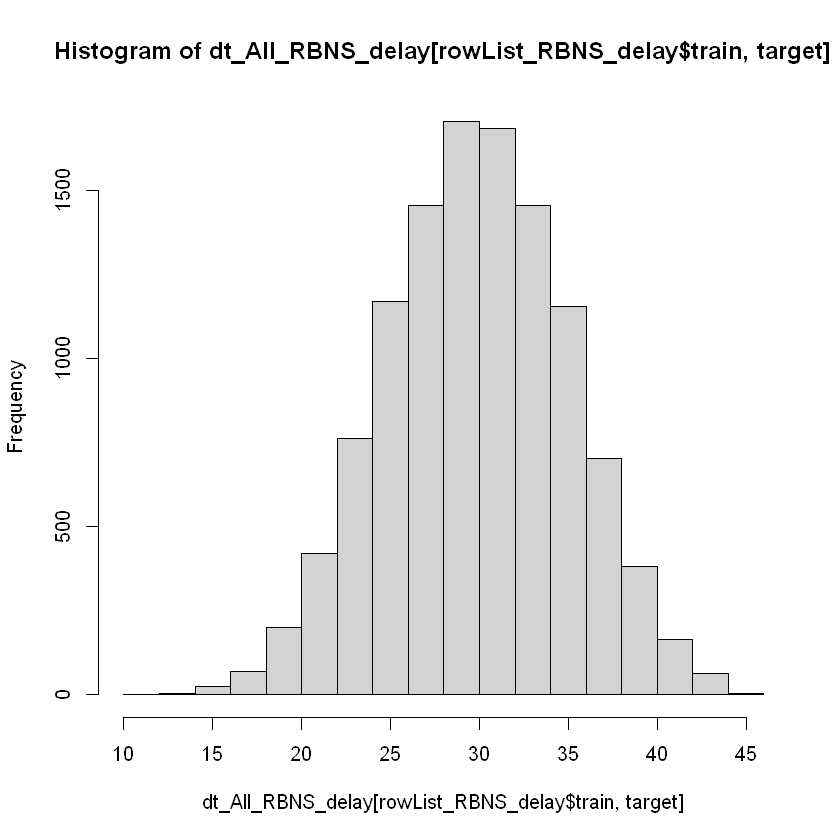

In [175]:
summary(dt_All_RBNS_delay[rowList_RBNS_delay$train, target])
hist(dt_All_RBNS_delay[rowList_RBNS_delay$train, target])

In [176]:
# XGBoost parameters - regression for delay
param_delay <- list(
  objective = "reg:squarederror",  # Regression
  max_depth = 2L,
  subsample = 0.75,
  colsample_bytree = 0.8,
  min_child_weight = 10,
  eta = 0.1
)


In [177]:
# Run CV
set.seed(1984)  # reproducibility

xgb_RBNS_CV_delay <- xgb.cv(
  params = param_delay,
  data = xgb.RBNS_DMat.train_delay,
  nrounds = 500,
  nfold = 5,
  early_stopping_rounds = 10L,
  print_every_n = 10L,
  prediction = TRUE
)

# Print best nrounds
cat("Best nrounds (iteration):", xgb_RBNS_CV_delay$best_iteration, "\n")


[1]	train-rmse:5.084654+0.011777	test-rmse:5.087049+0.045697 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 10 rounds.

[11]	train-rmse:5.075272+0.011312	test-rmse:5.085313+0.045983 
[21]	train-rmse:5.068682+0.011189	test-rmse:5.083604+0.046545 
[31]	train-rmse:5.062905+0.011246	test-rmse:5.083678+0.045612 
Stopping. Best iteration:
[24]	train-rmse:5.066708+0.011261	test-rmse:5.083316+0.045870

Best nrounds (iteration): 24 


In [178]:
# Store out-of-fold CV predictions in training set
dt_All_RBNS_delay[rowList_RBNS_delay$train, preds_oof_delay := xgb_RBNS_CV_delay$pred]


In [179]:
head(dt_All_RBNS_delay)

clm_number,pol_number,j,k,date_pol_start,date_occur,date_report,date_pay,Cover,claim_type,...,Price,target,delay_rep_pay,flgTrain,Count,delay_uw_occ,delay_occ_rep,delay_uw_val,date_uw,preds_oof_delay
<chr>,<chr>,<int>,<int>,<dttm>,<dttm>,<dttm>,<dttm>,<fct>,<fct>,...,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
201601040001,201601010451,8,1,2016-01-01,2016-01-04,2016-01-12,2016-02-08,BO,B,...,728,27,27,1,1,3,8,270,16801,29.93707
201601040002,201601030437,8,1,2016-01-03,2016-01-04,2016-01-28,2016-02-29,BO,O,...,837,32,32,1,1,1,24,268,16803,28.94900
201601040003,201601040050,7,1,2016-01-04,2016-01-04,2016-02-13,2016-03-14,B,B,...,837,30,30,1,1,0,40,267,16804,29.76503
201601050001,201601020447,7,1,2016-01-02,2016-01-05,2016-02-12,2016-03-18,BO,B,...,728,35,35,1,1,3,38,269,16802,29.41366
201601060001,201601020675,8,1,2016-01-02,2016-01-06,2016-01-22,2016-02-26,BO,B,...,913,35,35,1,1,4,16,269,16802,29.72707
201601060002,201601050343,8,1,2016-01-05,2016-01-06,2016-01-06,2016-02-08,BOT,B,...,913,33,33,1,1,1,0,266,16805,28.85631


In [180]:

head(dt_All_RBNS_delay[rowList_RBNS_delay$train, .(target, preds_oof_delay)], 10)

target,preds_oof_delay
<dbl>,<dbl>
27,29.93707
32,28.94900
30,29.76503
35,29.41366
35,29.72707
33,28.85631
33,28.89486
31,28.90386
24,29.71155


In [181]:
dt_All_RBNS_delay[flgTrain == 1, .(pol_number,flgTrain,target, preds_oof_delay)]

pol_number,flgTrain,target,preds_oof_delay
<chr>,<dbl>,<dbl>,<dbl>
201601010451,1,27,29.93707
201601030437,1,32,28.94900
201601040050,1,30,29.76503
201601020447,1,35,29.41366
201601020675,1,35,29.72707
201601050343,1,33,28.85631
201601050442,1,33,28.89486
201601030514,1,31,28.90386
201601020387,1,24,29.71155


In [182]:
# Train final XGBoost model on full training set
xgb_RBNS_Fit_delay <- xgb.train(
  params = param_delay,
  data = xgb.RBNS_DMat.train_delay,
  nrounds = xgb_RBNS_CV_delay$best_iteration,
  watchlist = list(train = xgb.RBNS_DMat.train_delay, test = xgb.RBNS_DMat.test_delay),
  print_every_n = 10
)


[1]	train-rmse:5.084625	test-rmse:5.093303 
[11]	train-rmse:5.076159	test-rmse:5.128746 
[21]	train-rmse:5.071667	test-rmse:5.181227 
[24]	train-rmse:5.069624	test-rmse:5.183224 


In [183]:
# Predict on full dataset
dt_All_RBNS_delay[, preds_full_delay := predict(xgb_RBNS_Fit_delay, xgb.RBNS_DMat.all_delay)]

# head() actual vs full model prediction
head(dt_All_RBNS_delay[, .(target, preds_full_delay)], 10)


target,preds_full_delay
<dbl>,<dbl>
27,29.36053
32,29.88105
30,29.78683
35,29.84028
35,29.88105
33,29.44369
33,29.62030
31,29.63607
24,29.43259


Feature,Gain,Cover,Frequency,Importance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
delay_uw_val,0.284427507,0.2952084073,0.27941176,0.284427507
j,0.271106360,0.2697355943,0.22058824,0.271106360
delay_occ_rep,0.254489749,0.3535045786,0.30882353,0.254489749
Price,0.064862553,0.0254825391,0.05882353,0.064862553
Cover_BOT,0.052903017,0.0043816351,0.04411765,0.052903017
Brand,0.028119291,0.0302167475,0.02941176,0.028119291
claim_type_B,0.021615768,0.0001458924,0.01470588,0.021615768
Model,0.012532667,0.0004887395,0.02941176,0.012532667
claim_type_T,0.009943089,0.0208358662,0.01470588,0.009943089


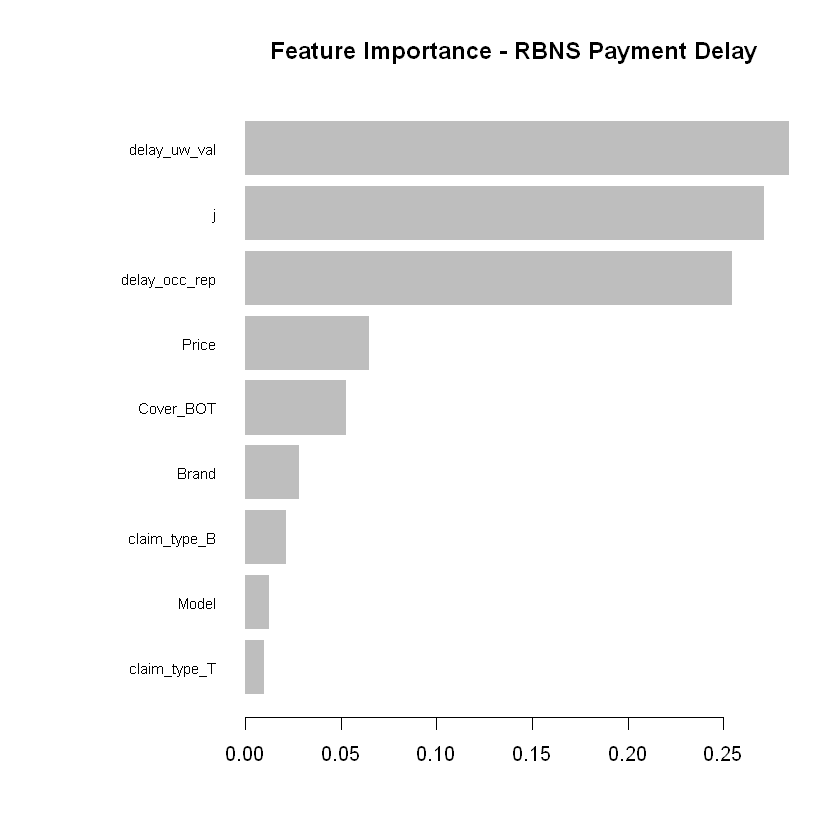

In [184]:
# Feature importance plot
featImp_RBNS_delay <- xgb.importance(xgb_RBNS_Fit_delay, feature_names = colnames(xgb.RBNS_DMat.train_delay))

# Plot
xgb.plot.importance(featImp_RBNS_delay, main = "Feature Importance - RBNS Payment Delay")

head(featImp_RBNS_delay, 10)


In [185]:
# Create YYYYMM field
dt_All_RBNS_delay[, date_occur_YYYYMM := as.character(year(date_occur) + month(date_occur)/100 )]

# Aggregate - compute averages per month
dt_RBNS_summary_delay_avg <- dt_All_RBNS_delay[rowList_RBNS_delay$test,
                                               .(avg_preds = mean(preds_full_delay),
                                                 avg_target = mean(target),
                                                 count = .N),  #number of claims that month
                                               keyby = date_occur_YYYYMM]

# difference and % diff
dt_RBNS_summary_delay_avg[, ':='(Diff = (avg_preds - avg_target),
                                 Diff_pcnt = scales::percent((avg_preds - avg_target) / avg_target, accuracy = 0.1))]

# View the table
head(dt_RBNS_summary_delay_avg, 15)


date_occur_YYYYMM,avg_preds,avg_target,count,Diff,Diff_pcnt
<chr>,<dbl>,<dbl>,<int>,<dbl>,<chr>
2016.04,30.91803,28.00000,20,2.91803036,10.4%
2016.05,31.09224,34.45455,110,-3.36230554,-9.8%
2016.06,29.62545,32.00000,350,-2.37455047,-7.4%
2016.07,29.58100,30.67021,1880,-1.08921221,-3.6%
2016.08,29.73162,31.40723,10510,-1.67561511,-5.3%
2016.09,29.70253,29.79927,19280,-0.09674316,-0.3%


In [186]:
# Global RMSE
preds_test_delay <- dt_All_RBNS_delay[rowList_RBNS_delay$test, preds_full_delay]
actual_test_delay <- dt_All_RBNS_delay[rowList_RBNS_delay$test, target]

# RMSE
rmse_delay <- sqrt(mean((preds_test_delay - actual_test_delay)^2))
cat("Global Test RMSE for Payment Delay:", rmse_delay, "\n")


Global Test RMSE for Payment Delay: 5.183224 


In [187]:
# MAE
mae_delay <- mean(abs(preds_test_delay - actual_test_delay))
cat("Global Test MAE for Payment Delay:", mae_delay, "\n")


Global Test MAE for Payment Delay: 4.176562 


In [188]:
# Per-month MAE and RMSE
dt_RBNS_summary_delay_avg <- dt_All_RBNS_delay[rowList_RBNS_delay$test,
                                               .(avg_preds = mean(preds_full_delay),
                                                 avg_target = mean(target),
                                                 MAE = mean(abs(preds_full_delay - target)),
                                                 RMSE = sqrt(mean((preds_full_delay - target)^2)),
                                                 count = .N),
                                           keyby = date_occur_YYYYMM]


dt_RBNS_summary_delay_avg[, ':='(Diff = (avg_preds - avg_target),
                                 Diff_pcnt = scales::percent((avg_preds - avg_target) / avg_target, accuracy = 0.1))]

head(dt_RBNS_summary_delay_avg, 15)


date_occur_YYYYMM,avg_preds,avg_target,MAE,RMSE,count,Diff,Diff_pcnt
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>
2016.04,30.91803,28.00000,2.918030,3.171797,20,2.91803036,10.4%
2016.05,31.09224,34.45455,3.518179,4.985293,110,-3.36230554,-9.8%
2016.06,29.62545,32.00000,4.222406,4.988149,350,-2.37455047,-7.4%
2016.07,29.58100,30.67021,4.079008,5.154092,1880,-1.08921221,-3.6%
2016.08,29.73162,31.40723,4.125733,5.135451,10510,-1.67561511,-5.3%
2016.09,29.70253,29.79927,4.218012,5.218125,19280,-0.09674316,-0.3%
